In [4]:

import numpy as np
import pandas as pd
import netCDF4 as nc
import geopandas as gpd
from netCDF4 import num2date
import datetime

from tqdm import tqdm

tqdm.pandas()
from shapely.geometry import Point

import matplotlib.pyplot as plt

import platform

from cartopy import crs as ccrs

if platform.system() == 'Darwin':
    plt.rcParams["font.family"] = 'Arial Unicode MS'
elif platform.system() == 'Windows':
    plt.rcParams["font.family"] = 'SimHei'
else:
    pass

In [5]:

nc_data = nc.Dataset("cru_ts4.05.1901.2020.tmp.dat.nc")

## 提取变量


In [6]:
raw_lat_data = np.array(nc_data.variables['lat'])
raw_lon_data = np.array(nc_data.variables['lon'])
raw_time_data = np.array(nc_data.variables['time'])
raw_tmp_data = np.array(nc_data.variables['tmp'])


<ipython-input-6-c2593932da71>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  raw_lat_data = np.array(nc_data.variables['lat'])
<ipython-input-6-c2593932da71>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  raw_lon_data = np.array(nc_data.variables['lon'])
<ipython-input-6-c2593932da71>:3: DeprecationWarning: `np.bool` is a deprecated alias for 

In [8]:
tmp_missing_value = nc_data.variables['tmp'].missing_value

## 导入中国边界数据

In [7]:
china_boundary = gpd.read_file(filename="数据集/中国地图边界202111版.json")

china_boundary_valid = china_boundary.copy()
china_boundary_valid['geometry'] = china_boundary.buffer(0)


In [9]:
def pic(lon, lat) -> bool:
    """
    检测一个点是否在中国边界线内
    lon:东经
    lat:北纬
    :param lon:
    :param lat:
    :return:
    """
    return china_boundary_valid.contains(Point(lon, lat))[0]

## 开始


In [11]:
raw_lon_data,
raw_lat_data

array([-89.75, -89.25, -88.75, -88.25, -87.75, -87.25, -86.75, -86.25,
       -85.75, -85.25, -84.75, -84.25, -83.75, -83.25, -82.75, -82.25,
       -81.75, -81.25, -80.75, -80.25, -79.75, -79.25, -78.75, -78.25,
       -77.75, -77.25, -76.75, -76.25, -75.75, -75.25, -74.75, -74.25,
       -73.75, -73.25, -72.75, -72.25, -71.75, -71.25, -70.75, -70.25,
       -69.75, -69.25, -68.75, -68.25, -67.75, -67.25, -66.75, -66.25,
       -65.75, -65.25, -64.75, -64.25, -63.75, -63.25, -62.75, -62.25,
       -61.75, -61.25, -60.75, -60.25, -59.75, -59.25, -58.75, -58.25,
       -57.75, -57.25, -56.75, -56.25, -55.75, -55.25, -54.75, -54.25,
       -53.75, -53.25, -52.75, -52.25, -51.75, -51.25, -50.75, -50.25,
       -49.75, -49.25, -48.75, -48.25, -47.75, -47.25, -46.75, -46.25,
       -45.75, -45.25, -44.75, -44.25, -43.75, -43.25, -42.75, -42.25,
       -41.75, -41.25, -40.75, -40.25, -39.75, -39.25, -38.75, -38.25,
       -37.75, -37.25, -36.75, -36.25, -35.75, -35.25, -34.75, -34.25,
      

In [33]:
single_data = raw_tmp_data[1,:,:].copy()
single_data[single_data == tmp_missing_value] = np.nan

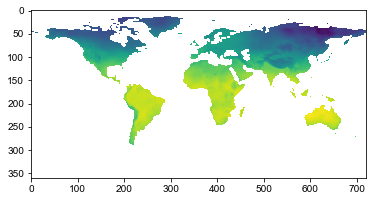

In [14]:
fig, ax = plt.subplots()
ax.imshow(single_data[::-1, :])

## 裁切


In [21]:
mask_matrix = np.full(shape=(360, 720), fill_value=False)
# mask_matrix[0,0] = True

In [18]:
# single_data[mask_matrix] = 20
# single_data

array([[20., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [22]:
mask_matrix = np.full(shape=(360, 720), fill_value=False)
for temp_lat in tqdm(range(360)):
    for temp_lon in range(720):
        point_lat_lon = (raw_lon_data[temp_lon], raw_lat_data[temp_lat])
        mask_matrix[temp_lat, temp_lon] = pic(lon=point_lat_lon[0], lat=point_lat_lon[1])


100%|██████████| 360/360 [00:58<00:00,  6.20it/s]


In [24]:
print('ok~')

ok~


In [34]:
single_data[~mask_matrix] = np.nan

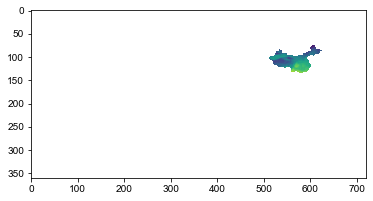

In [35]:
fig, ax = plt.subplots()
ax.imshow(single_data[::-1, :])

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [38]:
import rasterio
def array2gtiff(array, filename):
    """
    将一个矩阵保存为tiff文件,
    这里还可以设置tiff的crs和transofrm。更多，可以查看rasterio的官网或者下面的这个链接
    https://gis.stackexchange.com/questions/279953/numpy-array-to-gtiff-using-rasterio-without-source-raster
    :param array: shape:(row, col)
    :param filename:
    :return:
    """
    with rasterio.open(filename, 'w', driver='GTiff',
                       height=array.shape[0], width=array.shape[1],
                       count=1, dtype=str(array.dtype)) as f:
        f.write(array, 1)

# test function
array2gtiff(array=single_data[::-1,:], filename="结果/testchina.tiff")

/opt/anaconda3/envs/devc/lib/python3.8/site-packages/rasterio/__init__.py:230: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = writer(path, mode, driver=driver,


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])